<a href="https://colab.research.google.com/github/elliemci/chatbots/blob/main/translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Translation from English text to French text and syntesized speech audio

In [68]:
!pip install sentencepiece transformers

In [69]:
!pip install datasets

In [73]:
! pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 6.6 MB/s eta 0:00:00


In [70]:
!sudo apt-get install portaudio19-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
portaudio19-dev is already the newest version (19.6.0-1.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [71]:
# PyAudio supports real-time microphone input
!pip install pyaudio

In [2]:
#import sentencepiece

from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

In [74]:
# when passing task="translation_en_to_fr" initiates the default T5 transformer model; Helsinki-NLP the highest rating
translation_pipeline = pipeline("translation", model="Helsinki-NLP/opus-mt-en-fr")

text = "Hello friends! How nice to see you!"

translated_text = translation_pipeline(text)[0]['translation_text']

print(f"English: {text}")
print(f"French: {translated_text}")


English: Hello friends! How nice to see you!
French: Bonjour les amis! Quel plaisir de vous voir!


In [75]:
import torch

from transformers import AutoProcessor, AutoModelForTextToSpectrogram, SpeechT5HifiGan
from datasets import load_dataset
from IPython.display import Audio

# Load the pretrained text-to-speech model directly, since pipeline has now argument for setting the speaker embeding

# the processor converts the input text into tokens and converts the model's output back into human comprehensible format
processor = AutoProcessor.from_pretrained("Sandiago21/speecht5_finetuned_facebook_voxpopuli_french")
# speecht5_finetuned_facebook_voxpopuli_french model is SpeechT5 model, fine-tuned on Facebook VoxPopuli French dataset
model = AutoModelForTextToSpectrogram.from_pretrained("Sandiago21/speecht5_finetuned_facebook_voxpopuli_french")

# Tokenized tensor representation of the input text
inputs = processor(text=translated_text, return_tensors="pt", padding=True, truncation=True)

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
# tensor representation of speaker's voice characteristics; can adjust to sound specific
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)
# generate a representation of the spectrum of frequencies of the speech audio as it varies with time
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

# use Hugging Face vocoder model to convert the synthesized speech feature representation to a audio data;
# the HiFi-GAN model SpeechT5HifiGan has been. pretrained by microsoft
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

with torch.no_grad():
    speech = vocoder(spectrogram)

In [76]:
from IPython.display import Audio

# default speed of 1, i.e. normal
speed = 0.75

# Ask the user for the desired playback speed
speed = float(input("Enter the desired playback speed with 1.0 being normal: "))

# play the waveform adjusting the rate based on the user's input speed,
# mooving the speech tensor to the CPU and convert to numpy array
Audio(speech.cpu().numpy(), rate=22050 * speed, autoplay=True)

Enter the desired playback speed with 1.0 being normal: 0.75


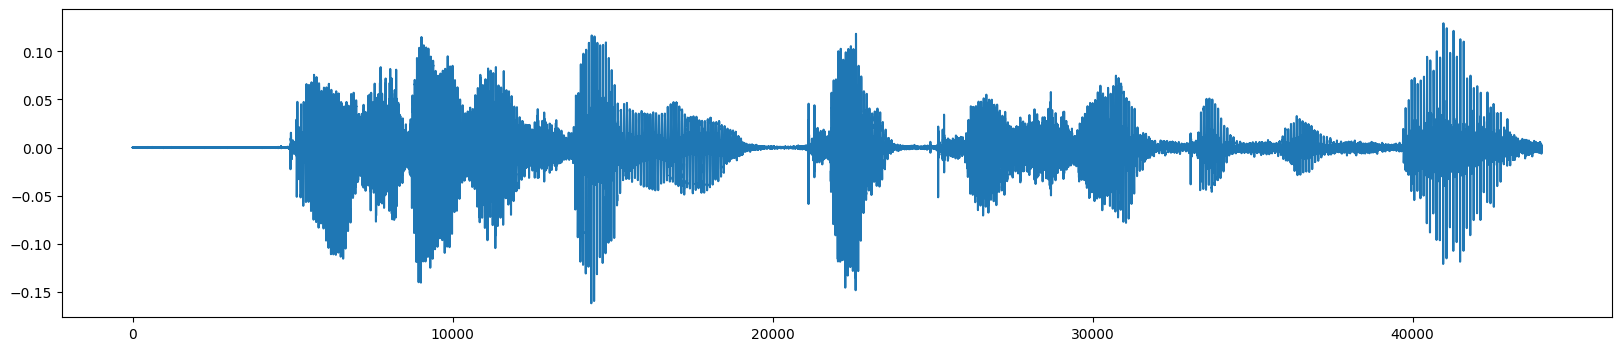

In [78]:
plt.figure(figsize=(20,4))
plt.plot(speech.t().cpu().numpy())